In [1]:
export = False


In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as stats
import torchaudio

import importlib

import dataloader
import evaluation

importlib.reload(evaluation)
from evaluation import RunEval
from dataloader import InsectDatamodule


run_path = "../logs/main_run/"
ex = RunEval(run_path)

datamodule = InsectDatamodule(csv_paths=['../data/Cicadidae.csv', '../data/Orthoptera.csv'], batch_size=10)
dataloader = datamodule.predict_dataloader()


In [25]:
# handle export of figures and tables
def save_or_show(object, object_type, file_name, export = False):

    figure_path = "../LaTeX/figures/"
    table_path = "../LaTeX/tables/"

    if object_type == 'figure':
        
        if export:
            plt.tight_layout()
            plt.savefig(f'{figure_path}{file_name}.pdf')
            plt.close()

        else:
            plt.tight_layout()
            plt.show()

    elif object_type == 'table':
        if export:
            with open(f'{table_path}{file_name}.tex', 'w') as f:
                f.write(object)

        else:
            print(object)
    
    else:
        print("Invalid object_type")
        

In [4]:
# Set global parameters for axis labels and tick sizes
plt.rcParams['axes.labelsize'] = 18  # Adjust the size of the axis labels
plt.rcParams['xtick.labelsize'] = 12  # Adjust the size of the x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Adjust the size of the y-axis tick labels
plt.rcParams['axes.titlesize'] = 20  # Adjust the size of the title



## Plotting the Visualization of the Transformation

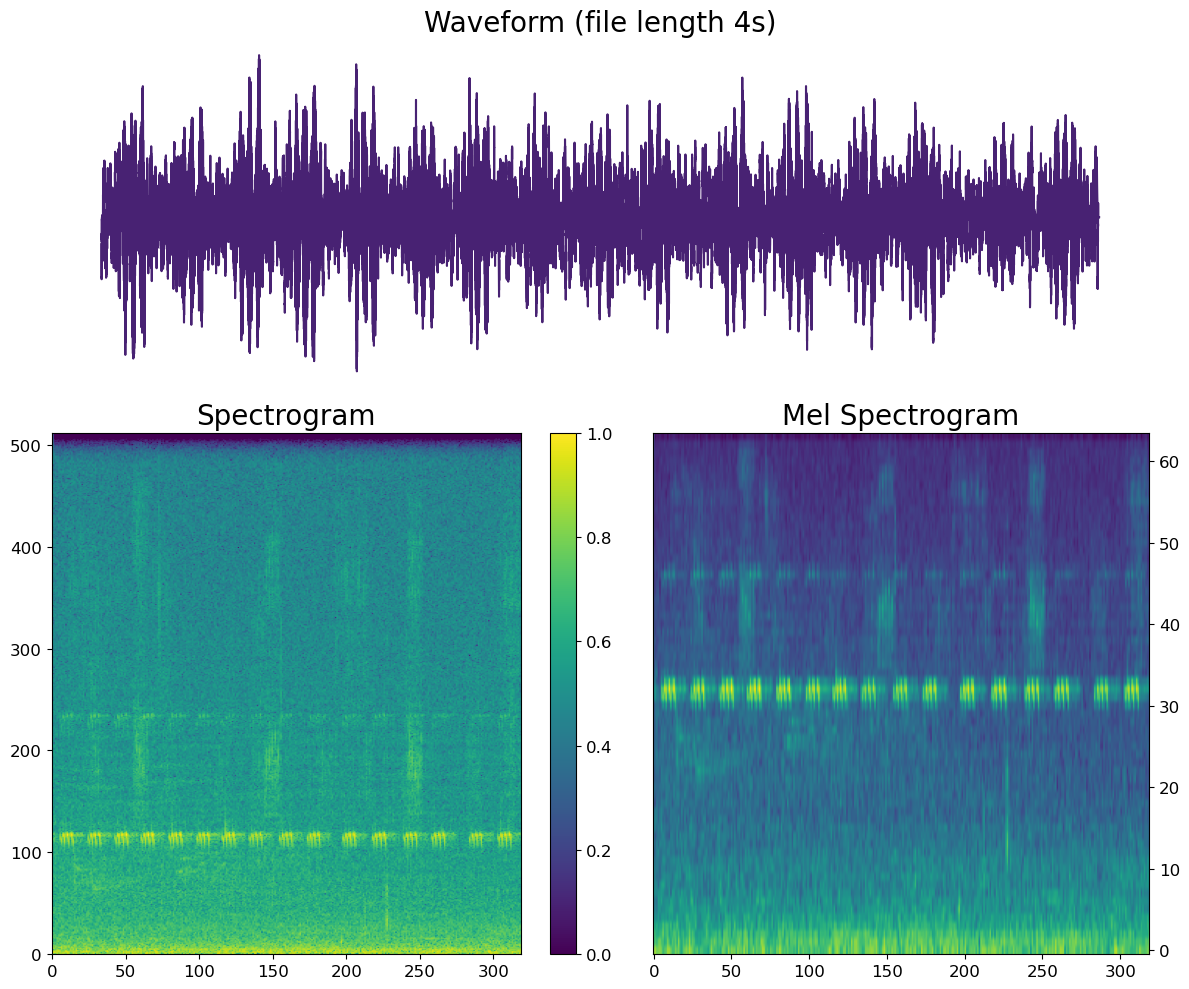

In [5]:
file_name = 'compare_spectrogram'
object_type = 'figure'

index = 200 #26
n_fft = 1024
top_db = None

metadata = dataloader.dataset.get_metadata()

waveform, sample_rate = dataloader.dataset.load_sample(metadata['path'][index])

def transform(waveform, sample_rate, n_mels, n_fft, top_db):
    if n_mels == -1:
        spec = torchaudio.transforms.Spectrogram(
                                                n_fft=n_fft, 
                                                hop_length=int(n_fft/2), 
                                                win_length=n_fft)(waveform)
    else:
        spec = torchaudio.transforms.MelSpectrogram(
                                                n_fft=n_fft,
                                                hop_length=int(n_fft/2),
                                                win_length=n_fft,
                                                n_mels=n_mels)(waveform)
        
    db_spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)

    norm_db_spec = (db_spec - db_spec.min()) / (db_spec.max() - db_spec.min())

    return norm_db_spec


fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[4, 6], width_ratios=[6.5, 5.5])

# upper plot
ax_upper = fig.add_subplot(gs[0, :])
time = np.arange(0, len(waveform[0])) / sample_rate
ax_upper.plot(time, waveform[0], color='#482273')
ax_upper.set_title(f'Waveform (file length {time.max():.0f}s)')
# ax_upper.set_xlabel('Time [s]')
# ax_upper.set_ylabel('Amplitude')

# Remove y-axis and frame
ax_upper.yaxis.set_visible(False)
ax_upper.xaxis.set_visible(False)
ax_upper.spines[['top', 'right', 'left', 'bottom']].set_visible(False)

# lower plot

for i, (title, n_mels) in enumerate(zip(
    ['Spectrogram', 'Mel Spectrogram'],
    [-1, 64])):

    spec = transform(waveform, sample_rate, n_mels, n_fft, top_db)
    
    fig.add_subplot(gs[1, i])
    plt.imshow(spec.numpy().squeeze(), origin='lower', aspect='auto')
    
    plt.title(title)

    if i == 0:
        plt.colorbar()
    else:
        plt.gca().yaxis.tick_right()

save_or_show(fig, object_type, file_name, export)


## Plotting  Visualizations for best Model

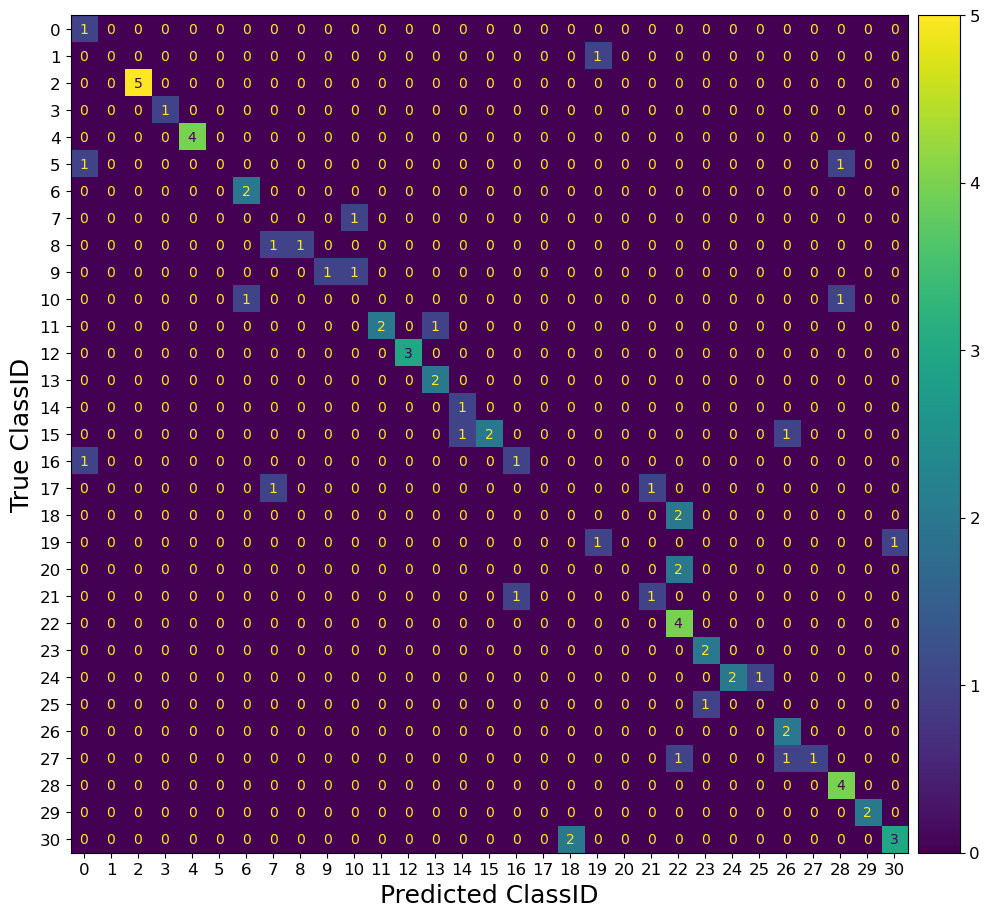

In [6]:
file_name = 'confusion_matrix_best'
object_type = 'figure'

index_best = ex.get_best_model()

y_true, y_pred = ex.get_predictions(index_best)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, colorbar=False)

# Label the axes
ax.set_xlabel('Predicted ClassID')
ax.set_ylabel('True ClassID')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

im = ax.imshow(cm, interpolation='nearest', cmap='viridis')
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)

save_or_show(fig, object_type, file_name, export)


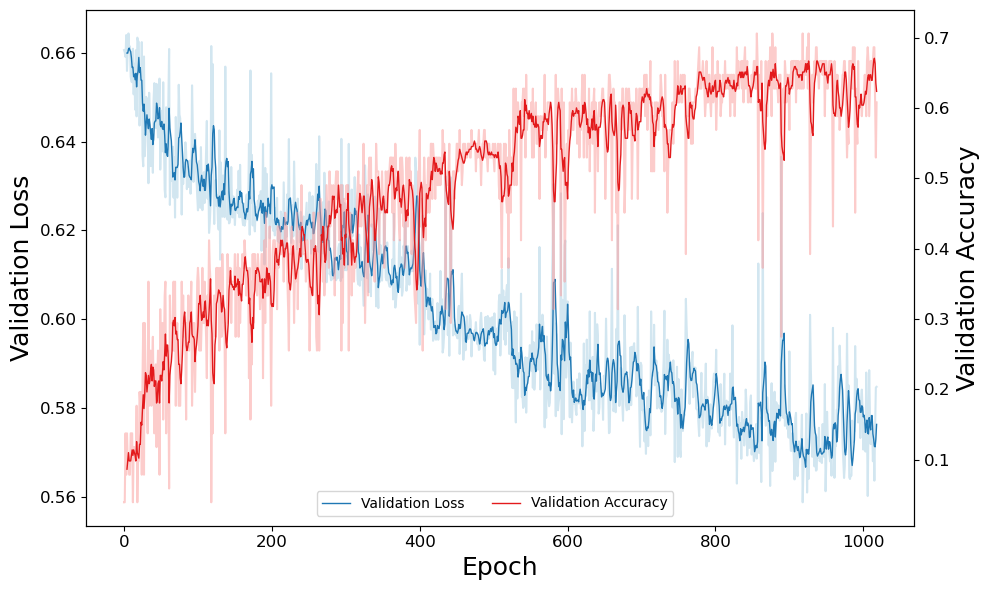

In [23]:
file_name = 'loss_acc_best'
object_type = 'figure'

def smooth_data(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

index_best = ex.get_best_model()
metrics = ex.train_log[index_best]

validation_data = metrics[~metrics['val_loss'].isnull()]

# Smooth the data
smoothed_val_loss = smooth_data(validation_data['val_loss'])
smoothed_val_acc = smooth_data(validation_data['val_acc'])

# Adjust the epoch range to match the length of the smoothed data
epochs = validation_data['epoch'][len(validation_data['epoch']) - len(smoothed_val_loss):]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot unsmoothed val_loss on the primary y-axis
ax1.plot(validation_data['epoch'], validation_data['val_loss'], color='#A6CEE3', label='', linewidth=1.5, alpha=0.5)
# Plot smoothed val_loss on the primary y-axis
ax1.plot(epochs, smoothed_val_loss, color='#1F78B4', label='Validation Loss', linewidth=1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Loss')
ax1.tick_params(axis='y')

# Create a secondary y-axis to plot val_acc
ax2 = ax1.twinx()
# Plot unsmoothed val_acc on the secondary y-axis
ax2.plot(validation_data['epoch'], validation_data['val_acc'], color='#FB9A99', label='', linewidth=1.5, alpha=0.5)
# Plot smoothed val_acc on the secondary y-axis
ax2.plot(epochs, smoothed_val_acc, color='#E31A1C', label='Validation Accuracy', linewidth=1)
ax2.set_ylabel('Validation Accuracy')
ax2.tick_params(axis='y')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, 0.12), ncol=2)

# fig.tight_layout()  # Adjust layout to fit everything

save_or_show(fig, object_type, file_name, export)


## Visualizing the Hyperparameter Tuning of the Model

In [26]:
file_name = 'hyperparameters_results'
object_type = 'table'

data = ex.summary

selection = ['n_mels', 'n_res_blocks', 'learning_rate', 'kernel_size', 'num_trainable_params', 'trained_epochs', 'accuracy', 'f1']

data_selected = pd.DataFrame()

for col in selection:
    if col in ['n_mels']:
        data_selected[col] = data[col].apply(lambda x: f"{x:.0f}")
    elif col in ['learning_rate']:
        data_selected[col] = data[col].apply(lambda x: f"{x:.3g}")
    elif col in ['accuracy', 'f1']:
        data_selected[col] = data[col].apply(lambda x: f"{x:.3f}")
    elif col in ['num_trainable_params']:
        data_selected[col] = data[col].apply(lambda x: f"{int(x):,}")
    else:
        data_selected[col] = data[col]

# Convert DataFrame to LaTeX table
latex_table = data_selected.to_latex(
    index=False, 
    column_format="rrrrrrrr"
)

# Manually replace the header row to make it bold
old_header = "n_mels & n_res_blocks & learning_rate & kernel_size & num_trainable_params & trained_epochs & accuracy & f1 \\"
new_header = "\\textbf{n\\_mels} & \\textbf{res blocks} & \\textbf{learning rate} & \\textbf{kernel size}& \\textbf{parameters} & \\textbf{epochs} & \\textbf{accuracy} & \\textbf{F1} \\"
latex_table = latex_table.replace(old_header, new_header)

save_or_show(latex_table, object_type, file_name, export)


<IPython.core.display.Latex object>

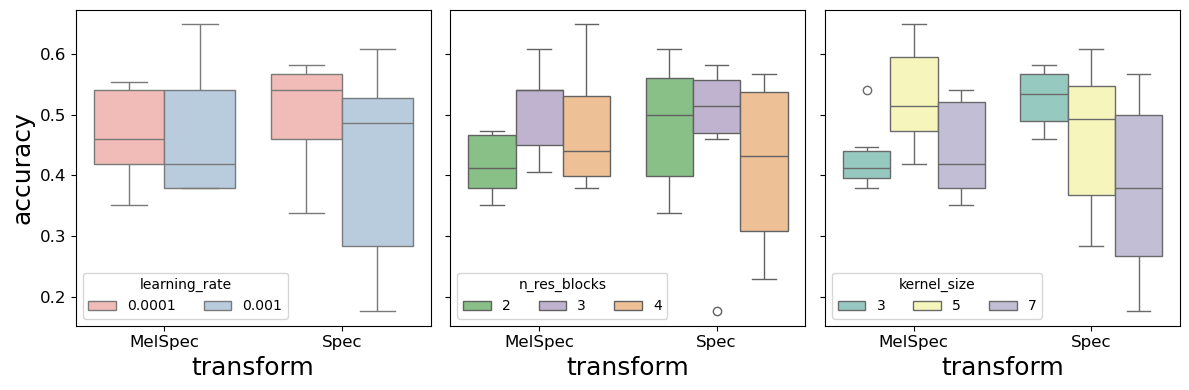

In [9]:
file_name = 'hyperparameters_boxplot'
object_type = 'figure'

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

for i, (hp, cmap) in enumerate(zip(
        ['learning_rate', 'n_res_blocks', 'kernel_size'],
        ['Pastel1', 'Accent', 'Set3'])):
    ax = axes[i]
    sns.boxplot(
        data=ex.summary,
        x='transform',
        y='accuracy',
        palette=cmap,
        hue=hp,
        ax=ax)

    sns.move_legend(ax, 'lower left', ncols=3)

    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

save_or_show(fig, object_type, file_name, export)


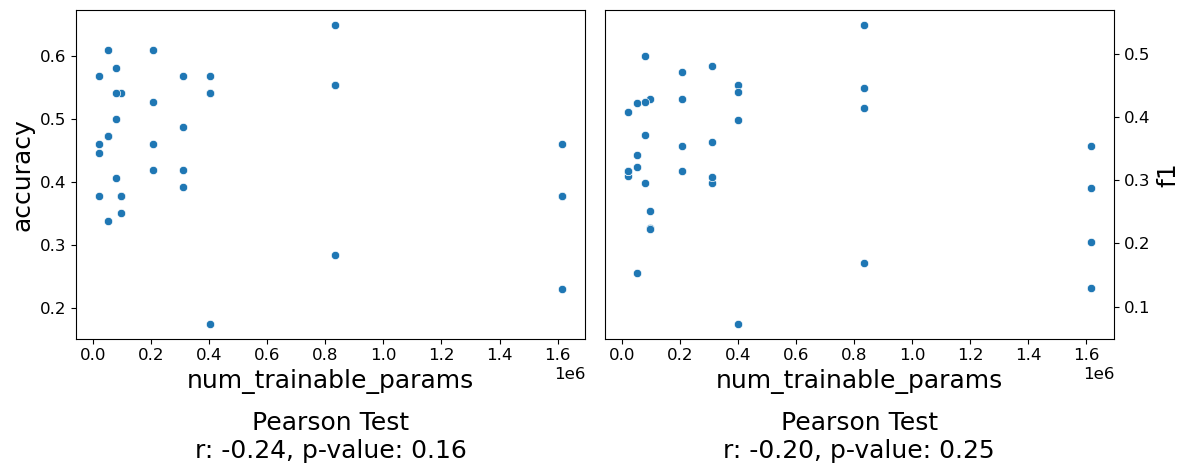

In [10]:
file_name = 'hyperparameters_scatterplot'
object_type = 'figure'

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

for i, metric in enumerate(['accuracy', 'f1']):

    pearson_corr, p_value = stats.pearsonr(ex.summary[metric], ex.summary['num_trainable_params'])

    ax = axes[i]
    sns.scatterplot(
        data=ex.summary,
        x='num_trainable_params',
        y=metric,
        # hue='transform',
        # palette='viridis',
        ax=ax)
    
    if i > 0:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
    
    ax.text(0.5, -0.3, f'Pearson Test\nr: {pearson_corr:.2f}, p-value: {p_value:.2f}',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)

    # sns.move_legend(ax, 'right', ncols=3)

save_or_show(fig, object_type, file_name, export)


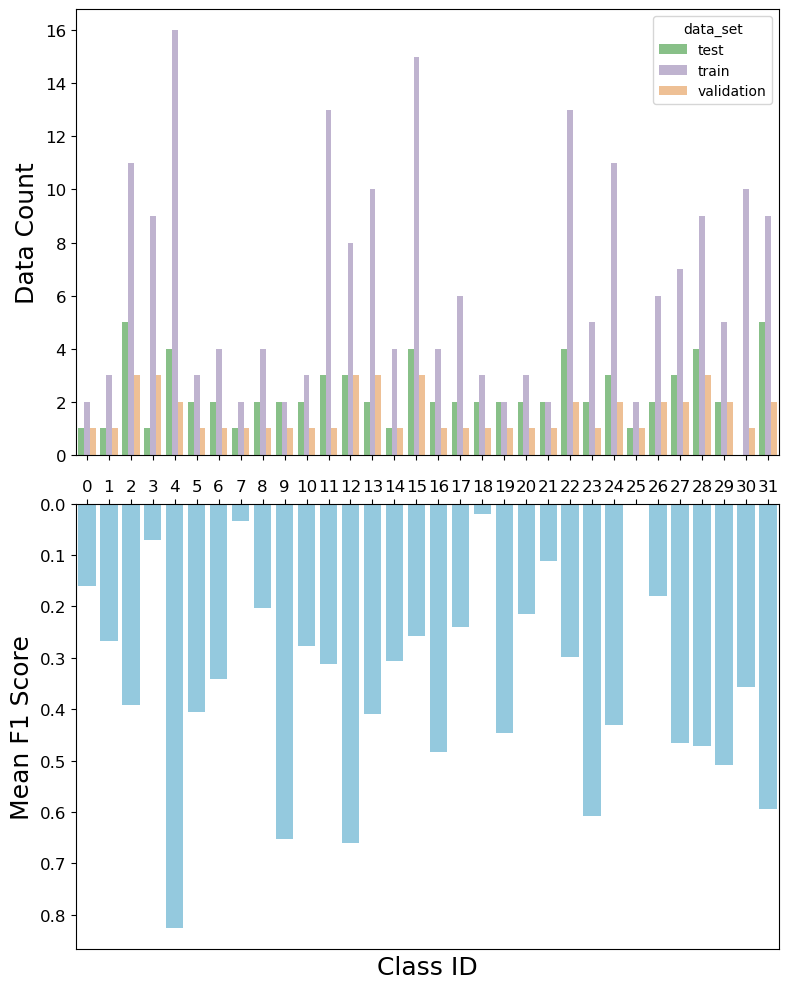

In [11]:
file_name = 'f1_per_class'
object_type = 'figure'

metadata = dataloader.dataset.get_metadata()
grouped = metadata.groupby(['class_id', 'data_set']).size().unstack(fill_value=0).reset_index()
melted = grouped.melt(id_vars='class_id', var_name='data_set', value_name='count')

f1_per_class = ex.f1_per_class.mean()


fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Plot 1: Count of Class ID by Data Set
sns.barplot(
    data=melted, 
    x='class_id', 
    y='count', 
    hue='data_set',
    palette = 'Accent', 
    ax=axes[0])
axes[0].set_ylabel('Data Count')

# Plot 2: Mean F1 Score per Class
sns.barplot(
    data=ex.f1_per_class.mean(),
    color = 'skyblue', 
    ax=axes[1]
)
axes[1].set_xlabel('Class ID')
axes[1].set_ylabel('Mean F1 Score')

# axes[1].xaxis.set_label_position('top')
axes[1].xaxis.tick_top()
axes[1].invert_yaxis()

save_or_show(fig, object_type, file_name, export)


## creating a table showing the label and names of the insects

In [12]:
file_name = 'ClassID_legend'
object_type = 'table'

unique_class_id = metadata[['class_id', 'species']].drop_duplicates(subset=['class_id']).sort_values(by='class_id')

# Split data into two parts
half = len(unique_class_id) // 2 + len(unique_class_id) % 2
first_half = unique_class_id.iloc[:half].reset_index(drop=True)
second_half = unique_class_id.iloc[half:].reset_index(drop=True)

# Concatenate first half and second half side by side
concatenated = pd.concat([first_half, second_half], axis=1)

# Adjust column names for LaTeX output
concatenated.columns = ['ClassID', 'Species', 'ClassID', 'Species']

# Convert to LaTeX
latex_table = concatenated.to_latex(
    index=False, 
    column_format="rlrl",
    header=True
)

save_or_show(latex_table, object_type, file_name, export)


\begin{tabular}{rlrl}
\toprule
ClassID & Species & ClassID & Species \\
\midrule
0 & Azanicadazuluensis & 16 & Platypleurachalybaea \\
1 & Brevisianabrevis & 17 & Platypleuradeusta \\
2 & Chorthippusbiguttulus & 18 & Platypleuradivisa \\
3 & Chorthippusbrunneus & 19 & Platypleurahaglundi \\
4 & Grylluscampestris & 20 & Platypleurahirtipennis \\
5 & Kikihiamuta & 21 & Platypleuraintercapedinis \\
6 & Myopsaltaleona & 22 & Platypleuraplumosa \\
7 & Myopsaltalongicauda & 23 & Platypleurasp04 \\
8 & Myopsaltamackinlayi & 24 & Platypleurasp10 \\
9 & Myopsaltamelanobasis & 25 & Platypleurasp11cfhirtipennis \\
10 & Myopsaltaxerograsidia & 26 & Platypleurasp12cfhirtipennis \\
11 & Nemobiussylvestris & 27 & Platypleurasp13 \\
12 & Oecanthuspellucens & 28 & Pseudochorthippusparallelus \\
13 & Pholidopteragriseoaptera & 29 & Pycnasemiclara \\
14 & Platypleuracapensis & 30 & Roeselianaroeselii \\
15 & Platypleuracfcatenata & 31 & Tettigoniaviridissima \\
\bottomrule
\end{tabular}

